# Reconstruction of 3D-Maze images using an Autoencoder

The goal of this notebook it to replicate the experiment in biology using artifical neural networks.

This notebook has theese parts:
1. Exploration and pruning of the dataset
2. Defining the neural network 
3. Evaluating the performance



In [23]:
import numpy as np
import torch
import math 
import matplotlib.pyplot as plt
import pickle
import copy
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from ripser import ripser
from persim import plot_diagrams

seed_ = 123
torch.manual_seed(seed_)

In [24]:
class LoadMazeData(): # This class contains the functions to load the data and pre-process it
    def __init__(self):
        self.train_percentage = 0.9
        pass

    def load_data(self, filename):
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        return data

    def direction_to_angle(self, direction):
        dx, dy = direction  # Assuming direction is a tuple (dx, dy)
        angle_radians = math.atan2(dy, dx)
        return angle_radians
        
    def xy_to_polar (self, x,y): 
        radius = math.sqrt(x**2 + y**2)
        angle = math.atan2(y, x)  
        return radius, angle 

    def _load_data(self, circular = True):
        if circular:
            filename = "data/3d_maze_dataset_spinning.pkl"
        if not circular:
            filename = "data/3d_maze_dataset_walking_around.pkl"
        
        data = self.load_data(filename)
        
        images = np.array(data['images'])
        positions = np.array(data['positions'])
        directions = np.array(data['directions'])


        images = self.pre_process_images(images)


        xy_in_polar = [ self.xy_to_polar((positions[i][0]-4.5) /4.5 ,(positions[i][1]-4.5) /4.5 ) for i in range(len(positions))]
        pos_dir = np.array([[xy_in_polar[i][0],xy_in_polar[i][1], self.direction_to_angle((directions[i][0],directions[i][1]))] for i in range(len(positions))])
        
        num_samples = images.shape[0]
        train_size = int(num_samples * self.train_percentage)
        
        train_images = images[:train_size]
        train_pos_dir = pos_dir[:train_size]

        return train_images, train_pos_dir
    
    def save_pruned_data(self, to_delete):
        #removes to_delete from data
        filename = "data/3d_maze_dataset_walking_around.pkl"
        data = self.load_data(filename)
        filename_pruned = "data/3d_maze_dataset_pruned.pkl"
        #removing 
        for key in data.keys():
            data[key] = np.delete(data[key], to_delete, axis=0)

        print("removed ", len(to_delete), " samples")
        #saving
        with open(filename_pruned, 'wb') as file:
            pickle.dump(data, file)
        

    def pre_process_images(self, images):
        images = images / 255.0
        return images
    
    def post_process_images(self, images):
        images = images * 255.0
        return images

    def get_maze_layout(self):
        filename = "data/3d_maze_dataset_spinning.pkl"
        data = self.load_data(filename)
        maze_layout = np.array(data['maze_layout'])
        return maze_layout


Total number of images:
Images_circular shape:  (77, 64, 64, 3)
pos_dir_circular shape:  (77, 3)
Images_entire_maze shape:  (1400, 64, 64, 3)
pos_dir_entire_maze shape:  (1400, 3)
Example image:
[0.85801243 3.00141358 1.07050838]


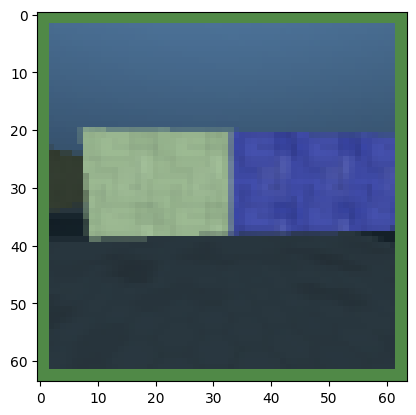

In [25]:
plt.rcParams['text.usetex'] = False
# Loading data 
data_loader = LoadMazeData()

images_circular, pos_dir_circular = data_loader._load_data(circular = True)
images_entire_maze, pos_dir_entire_maze  = data_loader._load_data(circular = False)
print("Total number of images:")
print("Images_circular shape: ", images_circular.shape)
print("pos_dir_circular shape: ", pos_dir_circular.shape)

print("Images_entire_maze shape: ", images_entire_maze.shape)
print("pos_dir_entire_maze shape: ", pos_dir_entire_maze.shape)

print("Example image:")
plt.imshow(images_circular[71])
print(pos_dir_entire_maze[71]) 
# Pos dir format: [radius, angle, direction] # the square is 9x9 but the x,y corrdinates are converted to polar cooridnates, hence we get a radius and an angle.

The Layout of the maze:


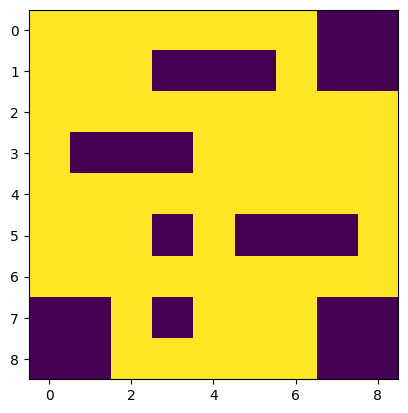

In [26]:
# Maze layout 
print("The Layout of the maze:")
maze_layout = data_loader.get_maze_layout()[0]
plt.imshow(maze_layout)


# Dataset analysis 

In the following, `sum_distance` refers to the distance between two points in the maze and the difference in their angles. Both are normalized to get a value ranging from 0 to 1. A difference of 1 between two points would indicate that the points are maximally far apart and the angles they are facing are 180 degrees apart.

In [27]:
class DatasetAnalysisAndPruning: 
    # This class contains the functions to analyse the dataset, calculate the bi-lipschitz constant, examine problematic images and prune the dataset
    def __init__(self, images, pos_dir, sigma = 1):
        self.images = images
        self.images_blurred = copy.deepcopy(images)
        self.pos_dir = pos_dir
        self.sigma = sigma
        self.images_unnormalised = copy.deepcopy(self.images)
        self.pos_dir_unnormalised = copy.deepcopy(self.pos_dir)

    def gaussian_blur(self, img):
        img = ndimage.gaussian_filter(img, sigma=self.sigma)
        return img
    
    def euclidean_distance_in_polar_coordinates(self, r1, theta1, r2, theta2):
        return np.sqrt(r1**2 + r2**2 - 2*r1*r2*np.cos(theta2 - theta1))
    
    def angle_difference(self, angle1, angle2):
        angle1 = angle1 + np.pi
        angle2 = angle2 + np.pi
        angle_dist = min(abs(angle1 - angle2), 2*np.pi - abs(angle1 - angle2)) 
        return angle_dist
    
    def l2_norm(self, img1, img2):
        return np.linalg.norm(img1 - img2)
    
    def comput_bi_lipschitz_constant(self, distances_L2, sum_distances):
        L_1 = np.inf
        L_2 = 0
        for i in range(len(distances_L2)):
            for j in range(len(distances_L2)):
                if i != j:
                    if sum_distances[i, j] > 0.00001: # excludes duplicate images
                        L_1 = min(L_1,   distances_L2[i, j]/sum_distances[i, j] )
                        L_2 = max(L_2,  distances_L2[i, j]/sum_distances[i, j] )
        return L_1, L_2

    def compute_pair_wise_distances(self, save=True, load=True, filename="entire_maze_distances", L2_max = -1 ):
        if load:
            self.distances_L2 = np.load(filename + "_L2.npy")
            self.distances_euclidean = np.load(filename + "_euclidean.npy")
            self.distances_angle = np.load(filename + "_angle.npy")
            self.sum_distances = np.load(filename + "_sum.npy")     

            self.images_removed_duplicates = np.load(filename + "_images_removed_duplicates.npy")
            self.pos_dir_removed_duplicates = np.load(filename + "_pos_dir_removed_duplicates.npy")
            self.images = self.images_removed_duplicates
            self.pos_dir = self.pos_dir_removed_duplicates

            self.images_unnormalised = copy.deepcopy(self.images)
            self.pos_dir_unnormalised = copy.deepcopy(self.pos_dir)

            # Computing the bi-lipschitz constant
            L_1, L_2 = self.comput_bi_lipschitz_constant(self.distances_L2, self.sum_distances)
            print("Bi-Lipschitz constant L_1: ", L_1)
            print("Bi-Lipschitz constant L_2: ", L_2)
            
            return 0,0,0,0
        else:
            num_samples = self.images.shape[0]
            distances_L2 = np.zeros((num_samples, num_samples))
            distances_euclidean = np.zeros((num_samples, num_samples))
            distances_angle = np.zeros((num_samples, num_samples))

            for i in range(num_samples):
                for j in range(i + 1, num_samples):
                    # gaussian_blur,
                    self.images_blurred[i] = self.gaussian_blur(self.images[i])
                    distances_L2[i, j] = self.l2_norm(self.images_blurred[i], self.images_blurred[j])
                    distances_euclidean[i, j] = self.euclidean_distance_in_polar_coordinates(self.pos_dir[i][0], self.pos_dir[i][1], self.pos_dir[j][0], self.pos_dir[j][1])
                    distances_angle[i, j] = self.angle_difference(self.pos_dir[i][2], self.pos_dir[j][2])

            distances_L2 = distances_L2 + distances_L2.T
            distances_euclidean = distances_euclidean + distances_euclidean.T
            distances_angle = distances_angle + distances_angle.T

            distances_L2, L2_max_new = self.normalise_distance_matrix(distances_L2,L2_max)
            if L2_max == -1:
                L2_max = L2_max_new
            
            distances_euclidean = distances_euclidean /4  # diameters of the unit circle * 2 to half it 
            distances_angle = distances_angle / ( 4*np.pi)

            self.distances_L2 = distances_L2
            self.distances_euclidean = distances_euclidean
            self.distances_angle = distances_angle
            self.sum_distances = (distances_euclidean + distances_angle) 

        # Finding all indices with nan
        nan_indices_sum_distances = np.argwhere(np.isnan(self.sum_distances))
        nan_indices_L2 = np.argwhere(np.isnan(self.distances_L2))
        nan_indices_euclidean = np.argwhere(np.isnan(self.distances_euclidean))
        nan_indices_angle = np.argwhere(np.isnan(self.distances_angle))





        # adding the nan indices to the list of indices to delete
        indices_to_delete = nan_indices_sum_distances


        # deleting the nan indices
        self.sum_distances = np.delete(self.sum_distances, indices_to_delete, axis=0)
        self.sum_distances = np.delete(self.sum_distances, indices_to_delete, axis=1)

        self.distances_L2 = np.delete(self.distances_L2, indices_to_delete, axis=0)
        self.distances_L2 = np.delete(self.distances_L2, indices_to_delete, axis=1)

        self.distances_euclidean = np.delete(self.distances_euclidean, indices_to_delete, axis=0)
        self.distances_euclidean = np.delete(self.distances_euclidean, indices_to_delete, axis=1)

        self.distances_angle = np.delete(self.distances_angle, indices_to_delete, axis=0)
        self.distances_angle = np.delete(self.distances_angle, indices_to_delete, axis=1)

        # Also delete the images and pos_dir
        self.images_removed_duplicates = np.delete(self.images, indices_to_delete, axis=0)
        self.pos_dir_removed_duplicates = np.delete(self.pos_dir, indices_to_delete, axis=0)        
        if save:
            np.save(filename + "_L2.npy", self.distances_L2)
            np.save(filename + "_euclidean.npy", self.distances_euclidean)
            np.save(filename + "_angle.npy", self.distances_angle)
            np.save(filename + "_sum.npy", self.sum_distances)

            #saving images_removed_duplicates and pos_dir_removed_duplicates with filename
            np.save(filename + "_images_removed_duplicates.npy", self.images_removed_duplicates)
            np.save(filename + "_pos_dir_removed_duplicates.npy", self.pos_dir_removed_duplicates)


        return self.distances_L2, self.distances_euclidean, self.distances_angle, L2_max

    def normalise_distance_matrix(self, distances,L2_max = -1):
        if L2_max != -1:
            return distances / L2_max , L2_max
        dist_max = np.max(distances)
        distances = distances / dist_max
        
        return distances, dist_max

    def plot_distance_matrix_as_a_heatmap(self, distances, title):

        # Create a custom color map
        colors = [(1, 1, 1), (0, 0, 1)]  # White to blue
        n_bins = 100  # Number of bins in the color map
        cmap_name = 'white_to_blue'
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

        plt.imshow(distances, cmap=cm, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar() 

        plt.title(title)
        plt.show()

    def plot_correlation_plot(self):
       # Flatten the arrays
        sum_distances_flat = self.sum_distances.flatten()
        distances_L2_flat = self.distances_L2.flatten()

        # Sort the flattened arrays
        sorted_indices = np.argsort(sum_distances_flat)
        sorted_sum_distances = sum_distances_flat[sorted_indices]
        sorted_distances_L2 = distances_L2_flat[sorted_indices]

        # Filter out (0,0) elements
        non_zero_indices = (sorted_sum_distances != 0) | (sorted_distances_L2 != 0)
        filtered_sum_distances = sorted_sum_distances[non_zero_indices]
        filtered_distances_L2 = sorted_distances_L2[non_zero_indices]

        # Plot the filtered data
        plt.scatter(filtered_sum_distances, filtered_distances_L2)
        plt.xlabel('Sorted Sum Distances')
        plt.ylabel('L2 Distances')
        plt.title('Scatter Plot of Sorted Sum Distances vs L2 Distances')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

    def polar_to_xy(self, r, theta):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return x, y
    
    def get_most_deviations(self):
        # Get largest element in the matrix

        max_diff = np.max(self.sum_distances - self.distances_L2)
        # In distance matrix, find largest value for  -(L2 - sum_distances) and largest value for -(sum_distances - L2)
        index_small_L2_large_dist = np.where(np.isclose(self.sum_distances - self.distances_L2, max_diff))

        index_0 = index_small_L2_large_dist[0][0]
        index_1 = index_small_L2_large_dist[1][0]
        print("----------------------------------------------------------------")
        print("Finding an image pair with small L2-Norm but large distance in sum_distances")
        print("Indicies of the largest difference: ", index_0, index_1)
        plt.imshow(self.images[index_0])
        plt.title("Image 1")
        plt.show()
        plt.imshow(self.images[index_1])
        plt.title("Image 2")
        plt.show()

        position_xy_img_1 = self.polar_to_xy(self.pos_dir[index_0][0], self.pos_dir[index_0][1])
        position_xy_img_2 = self.polar_to_xy(self.pos_dir[index_1][0], self.pos_dir[index_1][1])

        print("Pos dir 1 : ", position_xy_img_1, " angle: ", self.pos_dir[index_0][2])
        print("Pos dir 2 : ", position_xy_img_2, " angle: ", self.pos_dir[index_1][2])
        print("L2-difference between images ", self.distances_L2[index_0, index_1])
        print("sum_distance difference between positions ", self.sum_distances[index_0, index_1])


        index_large_L2_small_dist = np.where(np.isclose(self.distances_L2 - self.sum_distances, np.max(self.distances_L2 - self.sum_distances)))
        index_0 = index_large_L2_small_dist[0][0]
        index_1 = index_large_L2_small_dist[1][0]
        print("----------------------------------------------------------------")
        print("Finding an image pair with small distance in sum_distances but large L2-Norm")
        plt.imshow(self.images[index_0])
        plt.title("Image 3")
        plt.show()
        plt.imshow(self.images[index_1])
        plt.title("Image 4")
        plt.show()

        position_xy_img_1 = self.polar_to_xy(self.pos_dir[index_0][0], self.pos_dir[index_0][1])
        position_xy_img_2 = self.polar_to_xy(self.pos_dir[index_1][0], self.pos_dir[index_1][1])

        print("Pos dir 1 : ", position_xy_img_1, " angle: ", self.pos_dir[index_0][2])
        print("Pos dir 2 : ", position_xy_img_2, " angle: ", self.pos_dir[index_1][2])
        print("L2-difference between images ", self.distances_L2[index_0, index_1])
        print("sum_distance difference between positions ", self.sum_distances[index_0, index_1])

    def data_set_pruning(self, aggresion):  # 0 very aggressive, 1 not aggressive  i.e. no pruning

        pruned_images = self.images_unnormalised
        pruned_pos_dir = self.pos_dir_unnormalised
        # Iterate over the difference matrix and prune accordingly
        to_delete = set()  
        for i in range(len(self.distances_L2)): 
            # Getting distance vector, so the distance between the image and all other images /pos and all other pos
            distance_vector_L2 = self.distances_L2[i]
            distance_vector_euclidean = self.sum_distances[i]
            for j in range(1,len(distance_vector_euclidean)):
                if abs(distance_vector_L2[j] - distance_vector_euclidean[j]) > aggresion:
                    to_delete.add(j)
                    to_delete.add(i)

        

        pruned_images = self.images_unnormalised
        pruned_pos_dir = self.pos_dir_unnormalised
        to_delete = sorted(to_delete, reverse=True)

        for index in to_delete:
            pruned_images = np.delete(pruned_images, index, axis=0)
            pruned_pos_dir = np.delete(pruned_pos_dir, index, axis=0)
        print("images_unnormalised size: ", len(self.images_unnormalised))
        print("pruned_images size: ", len(pruned_images))

        
        # Return the pruned datasets
        return pruned_images, pruned_pos_dir, to_delete



## Pruning

First let us look at the dataset. We have a total of 1338 images, taking a pair, some have small L2-distance but are far apart, in space. And some are close by, but have a large L2-distance. The following code will find such pairs, and prune them.

Bi-Lipschitz constants of the entire maze
Bi-Lipschitz constant L_1:  0.22376894664930078
Bi-Lipschitz constant L_2:  8895.94042821915


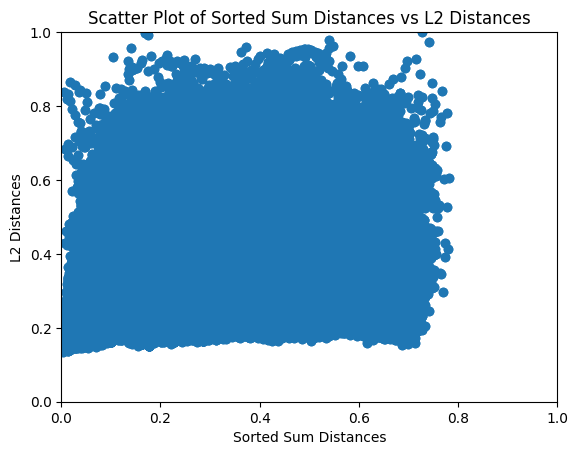

----------------------------------------------------------------
Finding an image pair with small L2-Norm but large distance in sum_distances
Indicies of the largest difference:  55 974


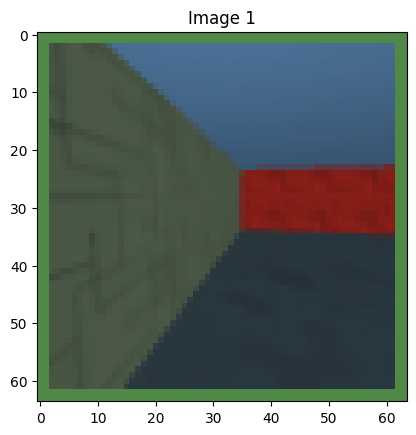

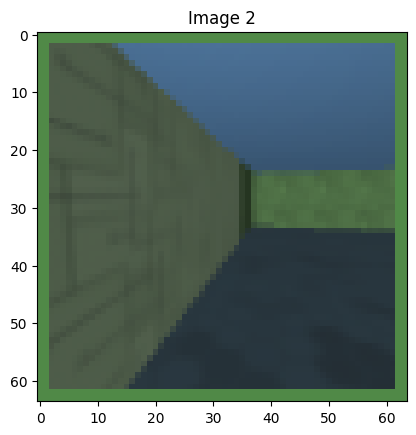

Pos dir 1 :  (-0.9252551124100596, -0.0681813082549259)  angle:  1.7751022250469248
Pos dir 2 :  (0.9231597957349121, 0.147535890517893)  angle:  -1.3297925252913025
L2-difference between images  0.1593950149468856
sum_distance difference between positions  0.7123196374369833
----------------------------------------------------------------
Finding an image pair with small distance in sum_distances but large L2-Norm


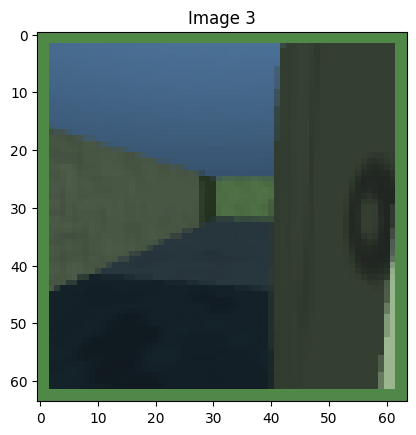

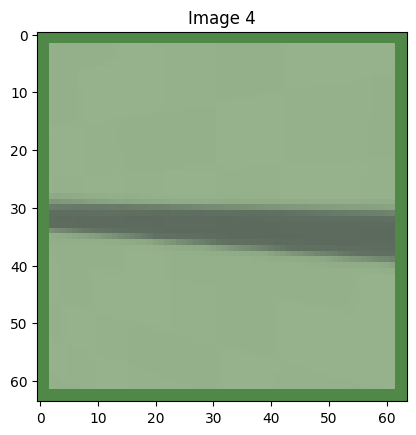

Pos dir 1 :  (0.7773688750494009, 0.35611574217248865)  angle:  -1.3562242543457648
Pos dir 2 :  (0.7589030995750891, 0.35455225185527417)  angle:  -1.1971211952971341
L2-difference between images  0.8656928222955695
sum_distance difference between positions  0.017293980989362252


In [28]:
entire_maze = True
print("Bi-Lipschitz constants of the entire maze")
if entire_maze:
    m = len(images_entire_maze) 

dataset_analysis_and_pruning = DatasetAnalysisAndPruning(images_entire_maze[:m], pos_dir_entire_maze[:m])
_, _,_,  L2_max = dataset_analysis_and_pruning.compute_pair_wise_distances(save=False, load=True, filename="data/entire_maze_distances")


L_1, L_2 = dataset_analysis_and_pruning.comput_bi_lipschitz_constant(dataset_analysis_and_pruning.distances_L2, dataset_analysis_and_pruning.sum_distances)

dataset_analysis_and_pruning.plot_correlation_plot()
dataset_analysis_and_pruning.get_most_deviations()


Note that there is very little correlation in the L2-Norm between being far apart and being close. This is of course to be expected, as pictures taken against the wall of different parts of a room look the same.
We can try to train the network with, or without such images.

images_unnormalised size:  1338
pruned_images size:  151
Pruned images shape:  (151, 64, 64, 3)
removed  1187  samples


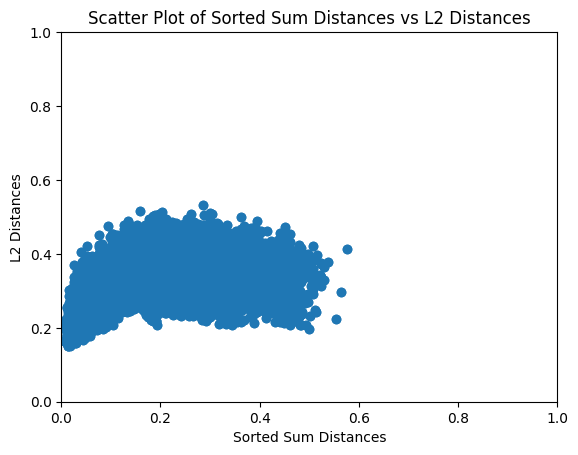

----------------------------------------------------------------
Finding an image pair with small L2-Norm but large distance in sum_distances
Indicies of the largest difference:  6 36


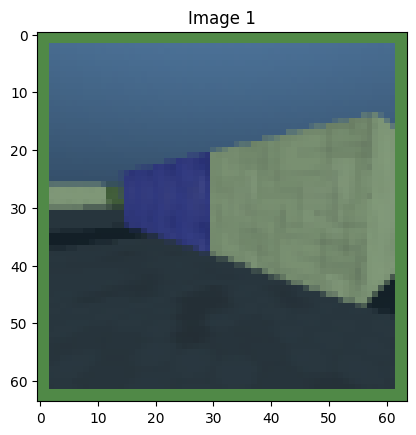

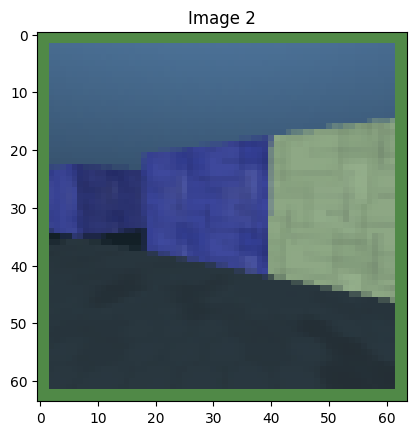

Pos dir 1 :  (-0.85020859395649, 0.12013632311281935)  angle:  -0.7151795574964516
Pos dir 2 :  (0.4308936988191321, -0.15660080435837978)  angle:  2.1189764135856892
L2-difference between images  0.22451484239704717
sum_distance difference between positions  0.5531977617788945
----------------------------------------------------------------
Finding an image pair with small distance in sum_distances but large L2-Norm


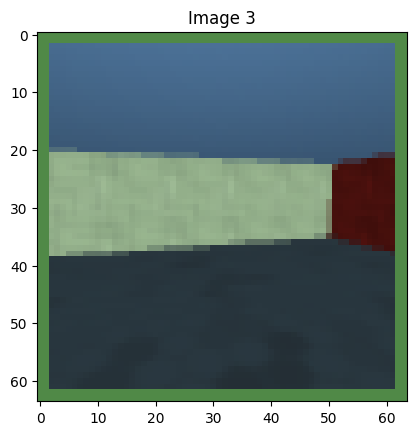

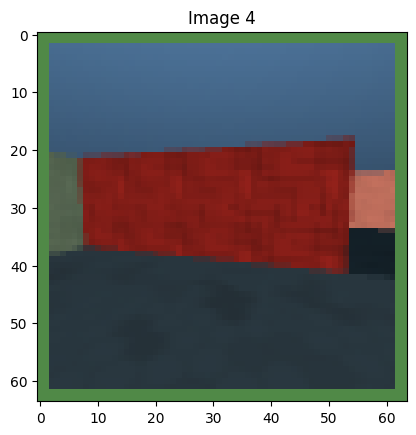

Pos dir 1 :  (-0.5748276612066465, 0.16178007255312707)  angle:  2.8404671369415206
Pos dir 2 :  (-0.6146592081006881, 0.23064577976614725)  angle:  1.8941444393520335
L2-difference between images  0.4741328192516021
sum_distance difference between positions  0.09519477997057048
Bi-Lipschitz constant of pruned dataset L_1:  0.3933339376275102
Bi-Lipschitz constant of pruned dataset L_2:  28.642827762118973


In [29]:
# Prune the dataset
pruned_images, pruned_pos_dir, to_delete = dataset_analysis_and_pruning.data_set_pruning(aggresion = 0.4)
print("Pruned images shape: ", pruned_images.shape)

temp_ = LoadMazeData()

#saving pruned data
temp_.save_pruned_data(to_delete)

dataset_analysis_and_pruning_with_pruned_images = DatasetAnalysisAndPruning(pruned_images, pruned_pos_dir)


dataset_analysis_and_pruning_with_pruned_images.compute_pair_wise_distances(load=False,save=False, L2_max = 43.50971202245282) # L2_max since the values will be renormalised otherwise and we cannot see the pruning
dataset_analysis_and_pruning_with_pruned_images.plot_correlation_plot()
dataset_analysis_and_pruning_with_pruned_images.get_most_deviations()
#computing the bi-lipschitz constant
L_1, L_2 = dataset_analysis_and_pruning_with_pruned_images.comput_bi_lipschitz_constant(dataset_analysis_and_pruning_with_pruned_images.distances_L2, dataset_analysis_and_pruning_with_pruned_images.sum_distances)
print("Bi-Lipschitz constant of pruned dataset L_1: ", L_1)
print("Bi-Lipschitz constant of pruned dataset L_2: ", L_2)





In [30]:
#calculating bilipschitz constants for spinning data
m = len(images_circular)
dataset_analysis_and_circular = DatasetAnalysisAndPruning(images_circular[:m], pos_dir_circular[:m])
_, _,_,  L2_max = dataset_analysis_and_circular.compute_pair_wise_distances(save=False, load=False, filename="data/circular_distances")

#calc 
#dataset_analysis_and_pruning.comput_bi_lipschitz_constant(dataset_analysis_and_pruning.distances_L2, dataset_analysis_and_pruning.sum_distances)

L_1, L_2 = dataset_analysis_and_pruning_with_pruned_images.comput_bi_lipschitz_constant(dataset_analysis_and_circular.distances_L2, dataset_analysis_and_circular.sum_distances)
print("Bi-Lipschitz constant of circular dataset L_1: ", L_1)
print("Bi-Lipschitz constant of circular dataset L_2: ", L_2)



Bi-Lipschitz constant of circular dataset L_1:  1.9375758835543382
Bi-Lipschitz constant of circular dataset L_2:  200.62653750015


An L_1 > 1 implies we can set L_1 = 1. 

# Defining the Autoencoder 

Now that we have examined the dataset, we will define the autoencoder. It is comprised of a CNN and a dense part. Using a CNN is standard practice when dealing with images.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64x3 -> 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 32x32x32 -> 16x16x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 16x16x64 -> 8x8x128
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 8x8x128 -> 4x4x256
            nn.ReLU()
        )

        self.encoder_dense = nn.Sequential(
            nn.Linear(4*4*256, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

        # Decoder
        self.decoder_dense = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4*4*256),
            nn.ReLU()
        )

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4x4x256 -> 8x8x128
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 8x8x128 -> 16x16x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16x16x64 -> 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),   # 32x32x32 -> 64x64x3
            nn.Sigmoid() )  

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = x.reshape(x.size(0), 256*4*4)  # Flatten
        x = self.encoder_dense(x)
        x = self.decoder_dense(x)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape
        x = self.decoder_cnn(x)
        return x
    
    def encode(self,x):
        x = self.encoder_cnn(x)
        x = x.reshape(x.size(0), 256*4*4)  # Flatten
        x = self.encoder_dense(x)
        return x 

# Training runs


We will do the following training runs:

Dataset:                            | Latent space size 

1. Entire maze dataset no pruning   | 3, 12 , 128
2. Entire maze dataset with pruning | 3, 12 , 128
3. Spinning maze dataset            | 2, 12 , 128 

During training we will examine the latent space every few iterations. We will compute the barcode and do a principle component analysis. 

Our aim is to find the circular/torus strucutre.

(spinning here means that the images were generated by rotating in a cirlce)



In [32]:
def latent_space_analysis(model, data, name):
    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(data).cpu().numpy()

    # PCA 
    if encoded_data.shape[1] > 2:
        pca = PCA(n_components=3)
    else: 
        pca = PCA(n_components=2)
    pca.fit(encoded_data)
    encoded_data_pca = pca.transform(encoded_data)
    #Note if latent dim is 2 or 3 PCA does not do anything
    if encoded_data.shape[1] > 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(encoded_data_pca[:,0], encoded_data_pca[:,1], encoded_data_pca[:,2])
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        fig.savefig(name + "_pca_plot.png", dpi=300)
    else:
        fig = plt.figure()
        plt.scatter(encoded_data_pca[:,0], encoded_data_pca[:,1])
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        fig.savefig(name + "_pca_plot.png", dpi=300)
    np.save(name + "_pca.npy", encoded_data_pca)


    # Compute the persistence diagram
    diagrams = ripser(encoded_data, maxdim=2)['dgms']
    fig = plt.figure()
    plot_diagrams(diagrams, show=False)
    plt.title("Barcode plot")
    plt.savefig(name + "_barcode_plot.png", dpi=300)
    #saving barcode as pickel
    with open(name + "_barcode.pkl", 'wb') as file:
        pickle.dump(diagrams, file)
    #just saving the raw encoded points
    np.save(name + "_encoded.npy", encoded_data)

In [33]:
import torch
import time
import matplotlib.pyplot as plt

def train(model, train_loader, num_epochs, learning_rate, test_img, name_of_model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_values = []

    start_time = time.time()
    
    # Measure the time for one loop
    for epoch in range(num_epochs):
        print("modeL: ", name_of_model, " Epoch: ", epoch)
        for data in train_loader:
            img = data[0].to(device)  
        
            if img.shape[1] != 3:
                img = img.permute(0, 3, 1, 2)  # Change shape from [batch_size, height, width, channels] to [batch_size, channels, height, width]
            
            # Convert the image tensor to float32
            img = img.float()

            if test_img.shape[1] != 3:
                test_img = test_img.permute(0, 3, 1, 2)
            test_img = test_img.to(device).float()

            recon = model(img)
            loss = criterion(recon, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Save the current loss value
            loss_values.append(loss.item())
            
            # At the beginning, in the middle, and the end of training, we will do latent_space_analysis
            if epoch == 0 or epoch == int(num_epochs//2) or epoch == num_epochs - 1:
                latent_space_analysis(model, test_img, "data/" + name_of_model + "_epoch_" + str(epoch))
    
    end_time = time.time()
    
    time_per_loop = end_time - start_time
    total_time_estimate = time_per_loop * num_epochs * len(train_loader)
    
    print(f"Estimated training time: {total_time_estimate / 3600:.2f} hours")

    # Saving the loss values
    np.save(f"data/{name_of_model}_loss_values.npy", loss_values)

    # Save the loss values as a plot image
    plt.figure()
    plt.plot(loss_values)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.savefig(f"data/{name_of_model}_loss_plot.png")
    
    return model, loss_values



In [34]:
# Datasets 
latent_dims_entire = [3, 12, 128]
latent_dims_spinning = [2, 12, 128]

# Split ratio
split_ratio = 0.8 #train/test split ratio

# Function to split dataset into train and test sets
def split_data(images, pos_dir, split_ratio):
    len__ = len(images)
    train_images = images[:int(len__*split_ratio)]
    test_images = images[int(len__*split_ratio):]
    train_pos_dir = pos_dir[:int(len__*split_ratio)]
    test_pos_dir = pos_dir[int(len__*split_ratio):]
    return train_images, test_images, train_pos_dir, test_pos_dir

# Entire maze data without pruning
entire_maze_data_no_pruning_train_images, entire_maze_data_no_pruning_test_images, _, _ = split_data(
    torch.tensor(images_entire_maze), torch.tensor(pos_dir_entire_maze), split_ratio)

# Entire maze data with pruning
entire_maze_data_with_pruning_train_images, entire_maze_data_with_pruning_test_images, _, _ = split_data(
    torch.tensor(pruned_images), torch.tensor(pruned_pos_dir), split_ratio)

# Spinning data
spinning_data_train_images, spinning_data_test_images, _, _ = split_data(
    torch.tensor(images_circular), torch.tensor(pos_dir_circular), split_ratio)

# Dataloaders
entire_maze_data_no_pruning_train_loader = DataLoader(TensorDataset(entire_maze_data_no_pruning_train_images), batch_size=32, shuffle=True)
entire_maze_data_with_pruning_train_loader = DataLoader(TensorDataset(entire_maze_data_with_pruning_train_images), batch_size=32, shuffle=True)
spinning_data_train_loader = DataLoader(TensorDataset(spinning_data_train_images), batch_size=32, shuffle=True)


In [35]:
# Training the models

num_epochs = 300
learning_rate = 1e-3
train_models = False # Setting to True will take a long time to train, in particular because of the H_2 calculation

if train_models:
    #Entire maze data no pruning
    for latent_dim in latent_dims_entire:
        print(f"Training model entire_maze_data_no_pruning_ with latent dimension {latent_dim}")
        model = Autoencoder(latent_dim)
        model, _ = train(model, entire_maze_data_no_pruning_train_loader, num_epochs, learning_rate, entire_maze_data_no_pruning_train_images, "entire_maze_data_no_pruning_"+str(latent_dim))
        torch.save(model.state_dict(), f'data/entire_maze_data_no_pruning_{latent_dim}.pt')
        pass
    for latent_dim in latent_dims_entire:
        print(f"Training model entire_maze_data_with_pruning_ with latent dimension {latent_dim}")
        model = Autoencoder(latent_dim)
        model, _ = train(model, entire_maze_data_with_pruning_train_loader, 300, learning_rate, entire_maze_data_with_pruning_train_images, "entire_maze_data_with_pruning_"+str(latent_dim))
        torch.save(model.state_dict(), f'data/entire_maze_data_with_pruning_{latent_dim}.pt')

    for latent_dim in latent_dims_spinning:
        print(f"Training model spinning_data_ with latent dimension {latent_dim}")
        model = Autoencoder(latent_dim)
        model, _ = train(model, spinning_data_train_loader, 300, learning_rate, spinning_data_train_images, "spinning_data_"+str(latent_dim))
        torch.save(model.state_dict(), f'data/spinning_data_{latent_dim}.pt')
else:
    #loading 
    
    for latent_dim in latent_dims_entire:
        model = Autoencoder(latent_dim)
        model.load_state_dict(torch.load(f'data/entire_maze_data_no_pruning_{latent_dim}.pt', map_location=torch.device('cpu')))
        model.eval()

    for latent_dim in latent_dims_entire:
        model = Autoencoder(latent_dim)
        model.load_state_dict(torch.load(f'data/entire_maze_data_with_pruning_{latent_dim}.pt', map_location=torch.device('cpu')))
        model.eval()
        
    for latent_dim in latent_dims_spinning:
        model = Autoencoder(latent_dim)
        model.load_state_dict(torch.load(f'data/spinning_data_{latent_dim}.pt', map_location=torch.device('cpu')))
        model.eval()
        

# Analysis of results

We will now see how well our models performed.

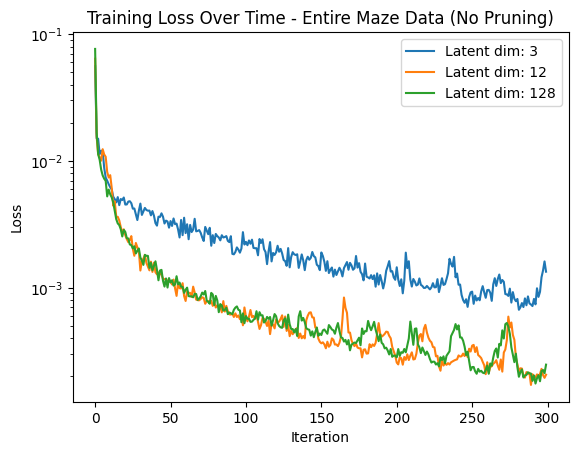

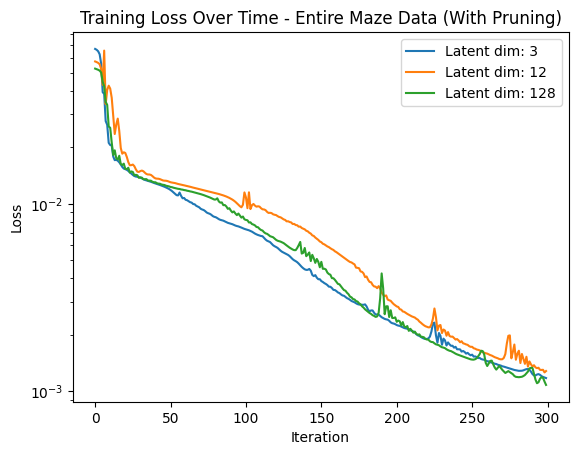

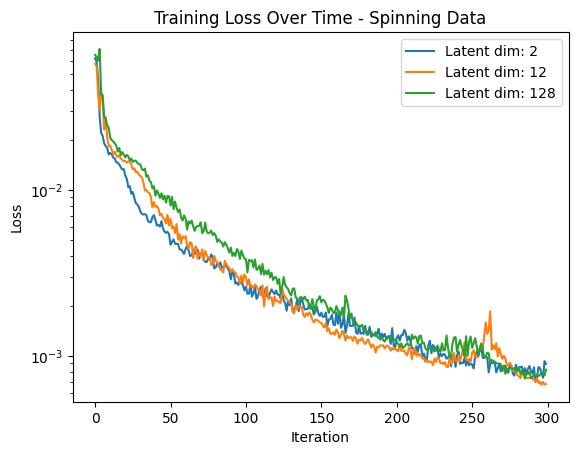

In [36]:
# Loading loss value, pca, barcode and encoded data for each model

# Entire maze data no pruning
loss_values_entire_maze_data_no_pruning = []
pca_entire_maze_data_no_pruning = []
barcode_entire_maze_data_no_pruning = []
encoded_entire_maze_data_no_pruning = []

epoch = 299
for latent_dim in latent_dims_entire:
    loss_values_entire_maze_data_no_pruning.append(np.load(f'data/entire_maze_data_no_pruning_{latent_dim}_loss_values.npy'))
    pca_entire_maze_data_no_pruning.append(np.load(f'data/entire_maze_data_no_pruning_{latent_dim}_epoch_{epoch}_pca.npy'))
    with open(f'data/entire_maze_data_no_pruning_{latent_dim}_epoch_{epoch}_barcode.pkl', 'rb') as file:
        barcode_entire_maze_data_no_pruning.append(pickle.load(file))
    encoded_entire_maze_data_no_pruning.append(np.load(f'data/entire_maze_data_no_pruning_{latent_dim}_epoch_{epoch}_encoded.npy'))

# Skip elements such that the length of the list is 300, this is because without pruning we have more data and hence more iterations
for i in range(len(loss_values_entire_maze_data_no_pruning)):
    loss_values_entire_maze_data_no_pruning[i]= [loss_values_entire_maze_data_no_pruning[i][j] for j in range(0,len(loss_values_entire_maze_data_no_pruning[i]), int(len(loss_values_entire_maze_data_no_pruning[i])/300))]
# Entire maze data with pruning

loss_values_entire_maze_data_with_pruning = []
pca_entire_maze_data_with_pruning = []
barcode_entire_maze_data_with_pruning = []
encoded_entire_maze_data_with_pruning = []

for latent_dim in latent_dims_entire:
    loss_values_entire_maze_data_with_pruning.append(np.load(f'data/entire_maze_data_with_pruning_{latent_dim}_loss_values.npy'))
    pca_entire_maze_data_with_pruning.append(np.load(f'data/entire_maze_data_with_pruning_{latent_dim}_epoch_{epoch}_pca.npy'))
    with open(f'data/entire_maze_data_with_pruning_{latent_dim}_epoch_{epoch}_barcode.pkl', 'rb') as file:
        barcode_entire_maze_data_with_pruning.append(pickle.load(file))
    encoded_entire_maze_data_with_pruning.append(np.load(f'data/entire_maze_data_with_pruning_{latent_dim}_epoch_{epoch}_encoded.npy'))

# Skip elements such that the length of the list is 300, this is because without pruning we have more data and hence more iterations
for i in range(len(loss_values_entire_maze_data_with_pruning)):
    loss_values_entire_maze_data_with_pruning[i]= [loss_values_entire_maze_data_with_pruning[i][j] for j in range(0,len(loss_values_entire_maze_data_with_pruning[i]), int(len(loss_values_entire_maze_data_with_pruning[i])/300))]


# Spinning data
loss_values_spinning_data = []
pca_spinning_data = []
barcode_spinning_data = []
encoded_spinning_data = []

for latent_dim in latent_dims_spinning:
    loss_values_spinning_data.append(np.load(f'data/spinning_data_{latent_dim}_loss_values.npy'))
    pca_spinning_data.append(np.load(f'data/spinning_data_{latent_dim}_epoch_{epoch}_pca.npy'))
    with open(f'data/spinning_data_{latent_dim}_epoch_{epoch}_barcode.pkl', 'rb') as file:
        barcode_spinning_data.append(pickle.load(file))
    encoded_spinning_data.append(np.load(f'data/spinning_data_{latent_dim}_epoch_{epoch}_encoded.npy'))

#skip elements such that the length of the list is 300
for i in range(len(loss_values_spinning_data)):
    loss_values_spinning_data[i]= [loss_values_spinning_data[i][j] for j in range(0,len(loss_values_spinning_data[i]), int(len(loss_values_spinning_data[i])/300))]

# Plotting the loss values with log scale
plt.figure()
for i, latent_dim in enumerate(latent_dims_entire):
    plt.plot(loss_values_entire_maze_data_no_pruning[i], label=f"Latent dim: {latent_dim}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss Over Time - Entire Maze Data (No Pruning)")
plt.legend()
plt.savefig("data/entire_maze_data_no_pruning_loss_plot_log.png")

plt.figure()
for i, latent_dim in enumerate(latent_dims_entire):
    plt.plot(loss_values_entire_maze_data_with_pruning[i], label=f"Latent dim: {latent_dim}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss Over Time - Entire Maze Data (With Pruning)")
plt.legend()
plt.savefig("data/entire_maze_data_with_pruning_loss_plot_log.png")

plt.figure()
for i, latent_dim in enumerate(latent_dims_spinning):
    plt.plot(loss_values_spinning_data[i], label=f"Latent dim: {latent_dim}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss Over Time - Spinning Data")
plt.legend()
plt.savefig("data/spinning_data_loss_plot_log.png")

    
    

In [37]:
### Testing each model 

# Testing reconstrion 
def test_reconstruction(model, test_image_set, random_seed = 123,name_of_model=""):

    img = torch.tensor(test_image_set, dtype=torch.float32)

    # Ensure the input tensor has the correct shape [batch_size, channels, height, width]
    if img.shape[1] != 3:
        img = img.permute(0, 3, 1, 2)  # Change shape from [batch_size, height, width, channels] to [batch_size, channels, height, width]
            



    # Choosing random images
    np.random.seed(random_seed)
    random_indices = np.random.choice(len(test_image_set), 3, replace=False)
    img = img[random_indices]

    # Reconstruct images
    outputs = model(img)
    

    # To image format, current format (3, 64, 64)
    img = img.permute(0, 2, 3, 1).detach().numpy()
    outputs = outputs.permute(0, 2, 3, 1).detach().numpy()
    


    # PLotting the 3 original vs the 3 reconstructed images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, ax in enumerate(axes[0]):
        ax.imshow(img[i])
        ax.axis('off')
        ax.set_title(name_of_model)
    for i, ax in enumerate(axes[1]):
        ax.imshow(outputs[i])
        ax.axis('off')
        ax.set_title('Reconstructed Image')
        

### No pruning reconstruction:

C:\Users\Fredi\AppData\Local\Temp\ipykernel_13884\4229992033.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



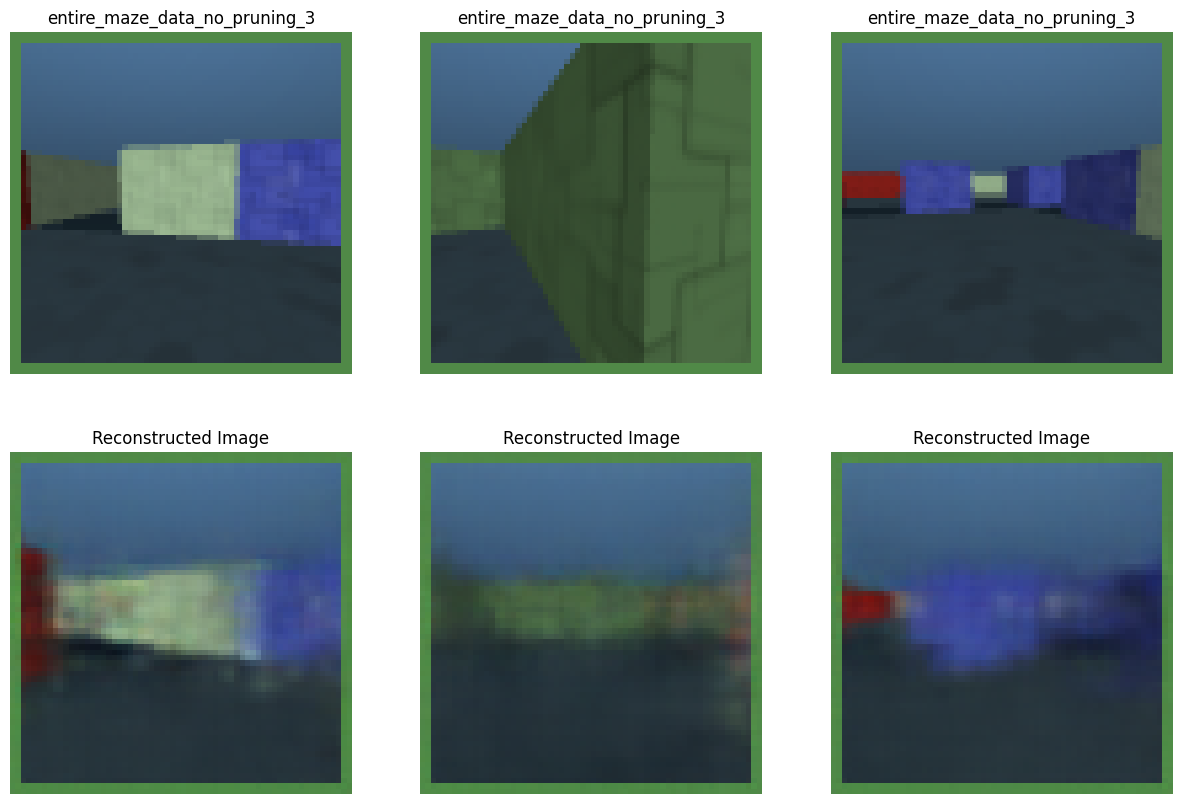

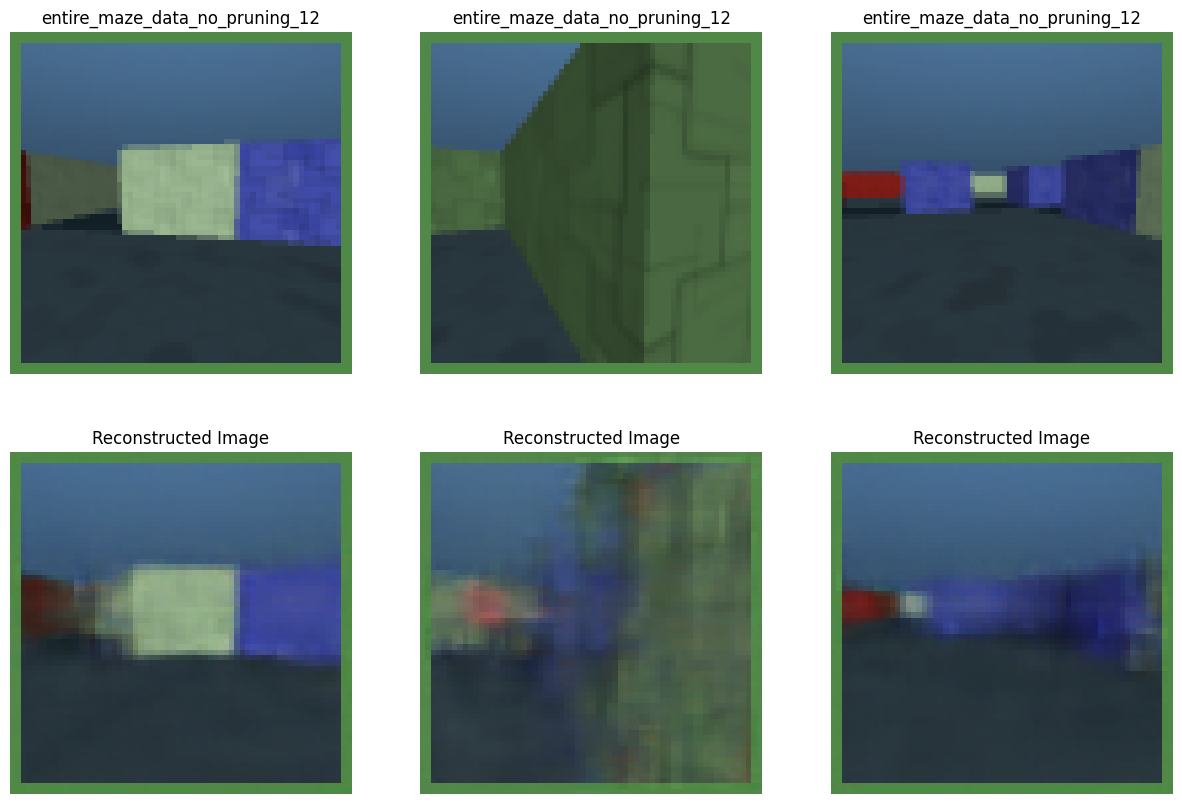

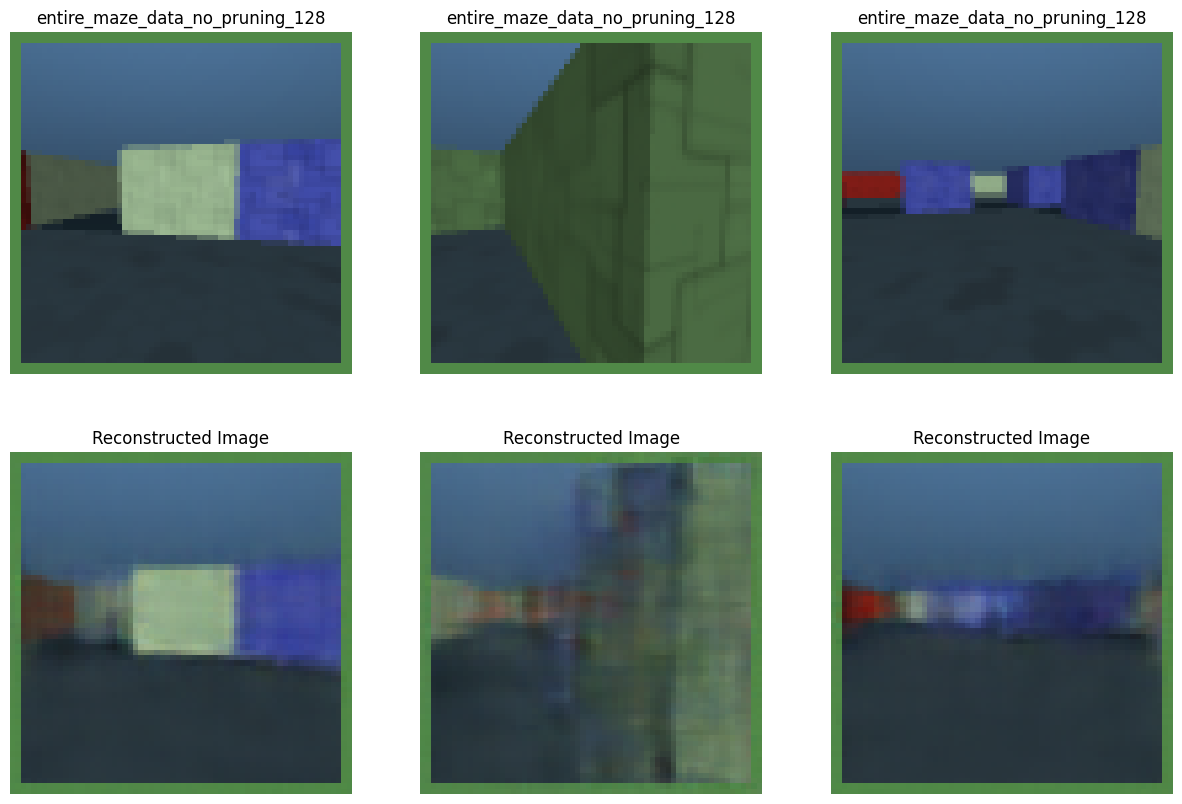

In [38]:
# Testing reconstruction for each 

# Entire maze data no pruning
for latent_dim in latent_dims_entire:
    model = Autoencoder(latent_dim)
    model.load_state_dict(torch.load(f'data/entire_maze_data_no_pruning_{latent_dim}.pt', map_location=torch.device('cpu')))
    model.eval()
    test_reconstruction(model, entire_maze_data_no_pruning_test_images, random_seed=124, name_of_model = "entire_maze_data_no_pruning_"+str(latent_dim))



### With pruning reconstruction:

C:\Users\Fredi\AppData\Local\Temp\ipykernel_13884\4229992033.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



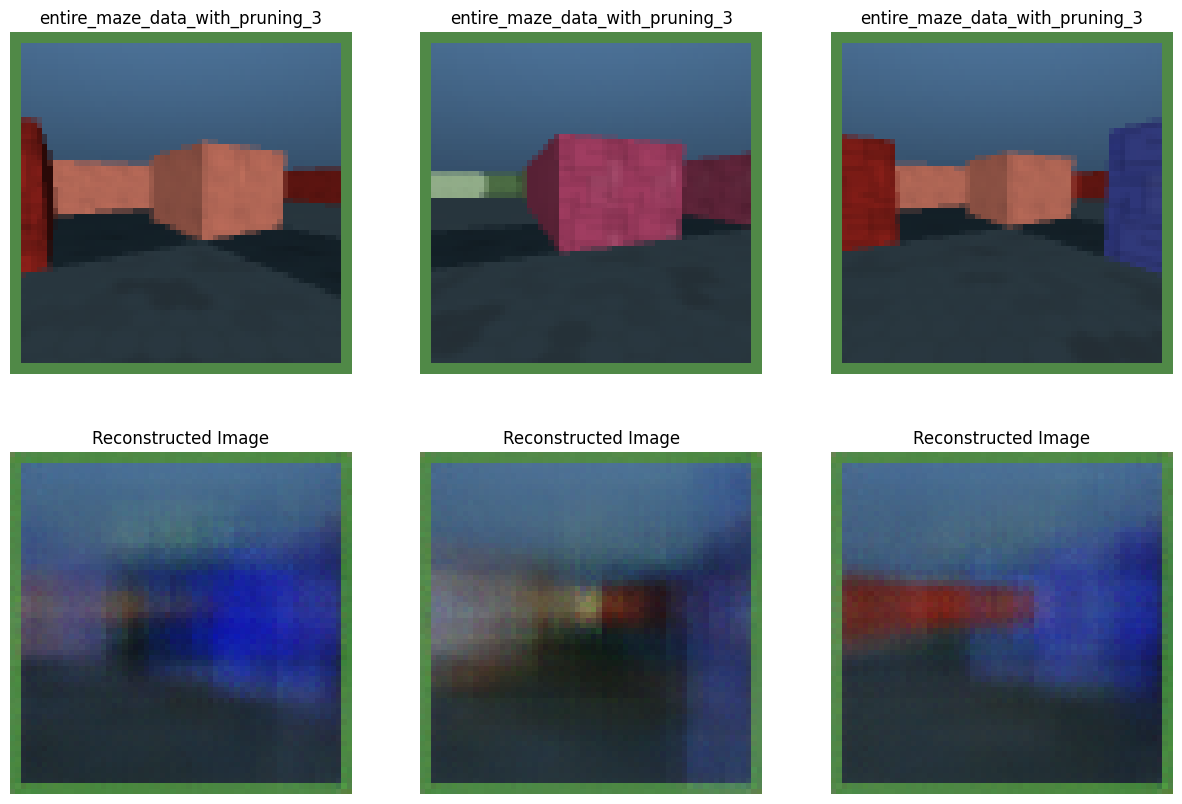

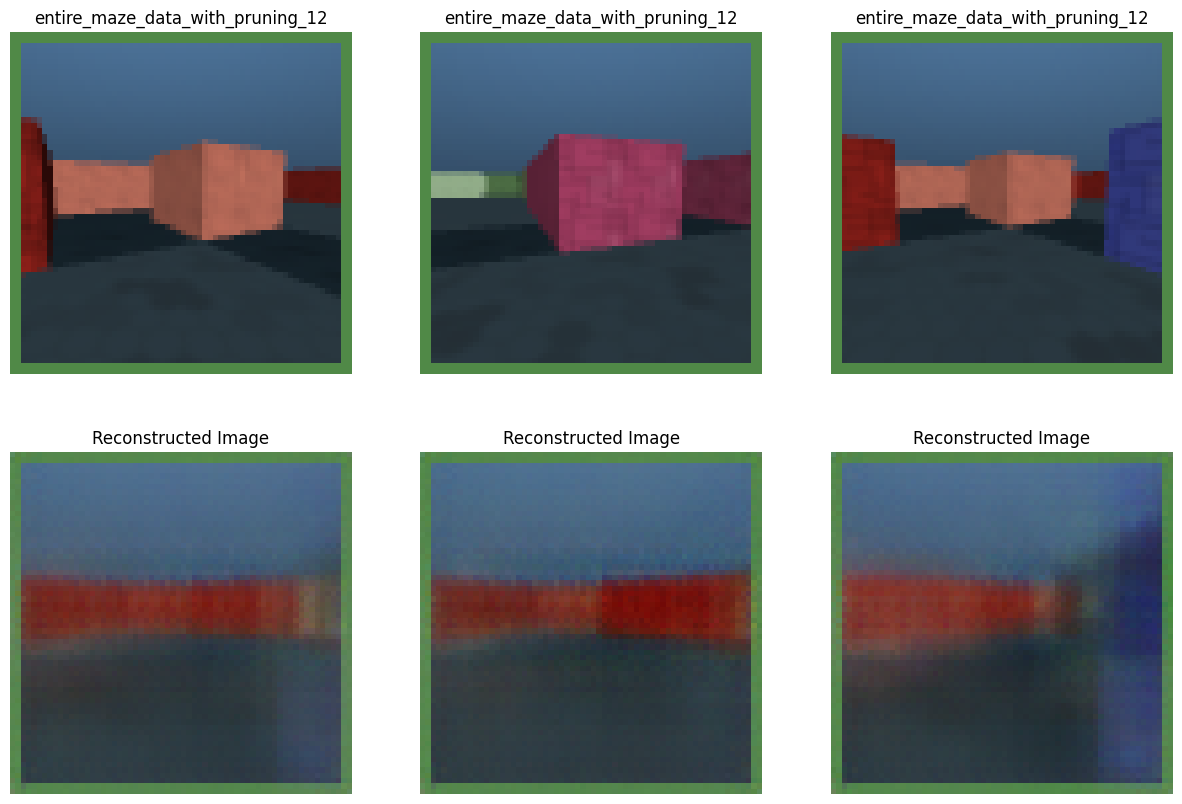

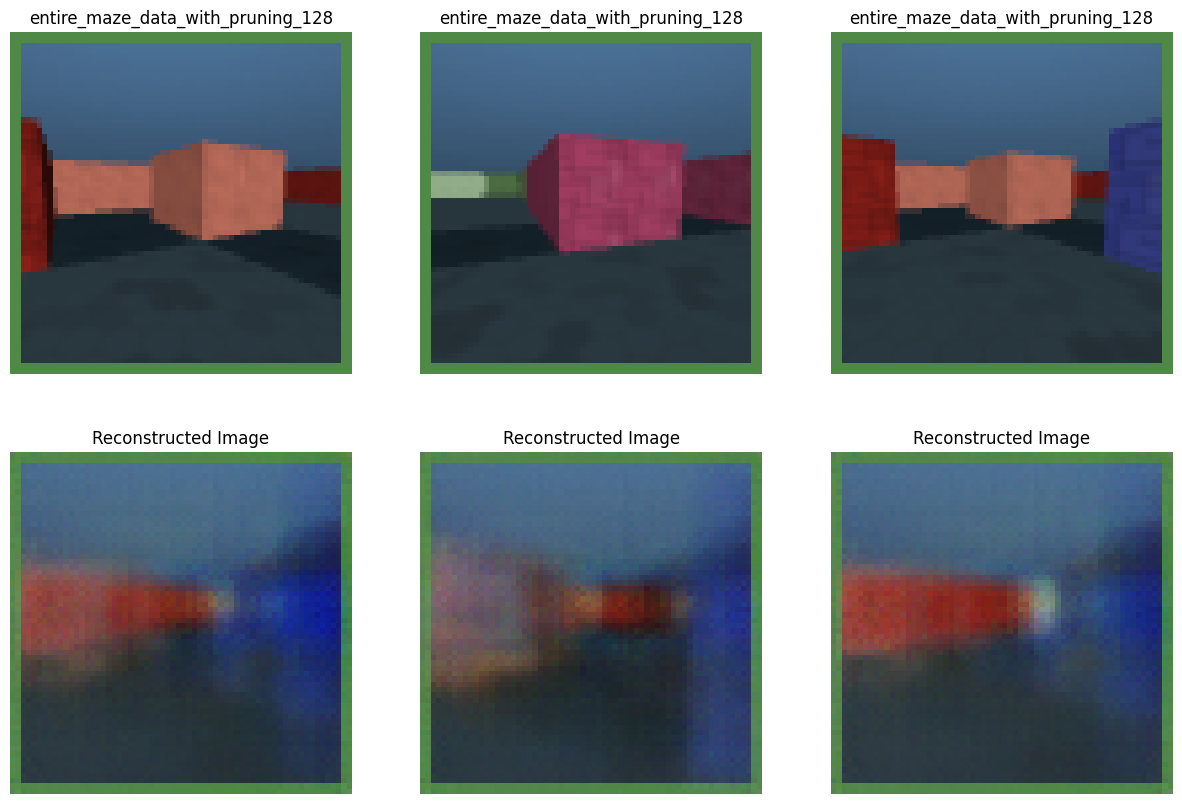

In [39]:

# Entire maze data with pruning
for latent_dim in latent_dims_entire:
    model = Autoencoder(latent_dim)
    model.load_state_dict(torch.load(f'data/entire_maze_data_with_pruning_{latent_dim}.pt', map_location=torch.device('cpu')))
    model.eval()
    test_reconstruction(model, entire_maze_data_with_pruning_test_images, random_seed=124, name_of_model = "entire_maze_data_with_pruning_"+str(latent_dim))

### Spinning  reconstruction:

C:\Users\Fredi\AppData\Local\Temp\ipykernel_13884\4229992033.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



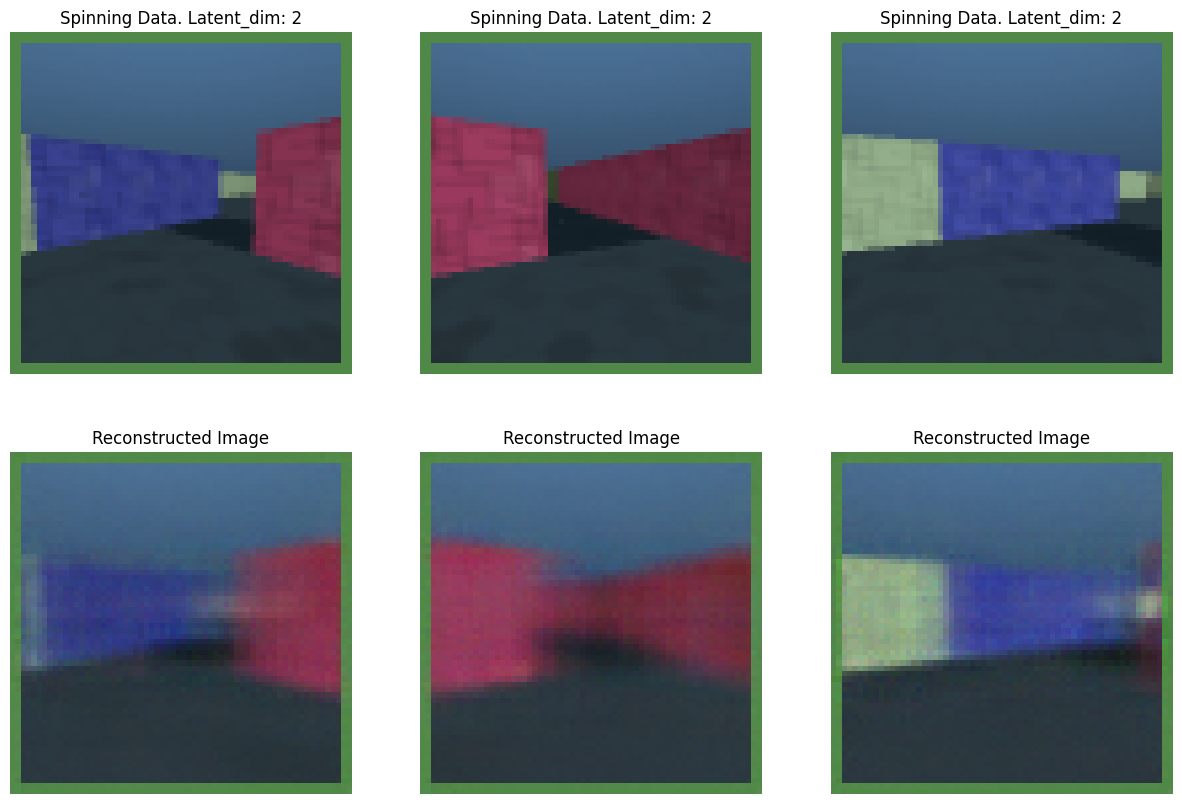

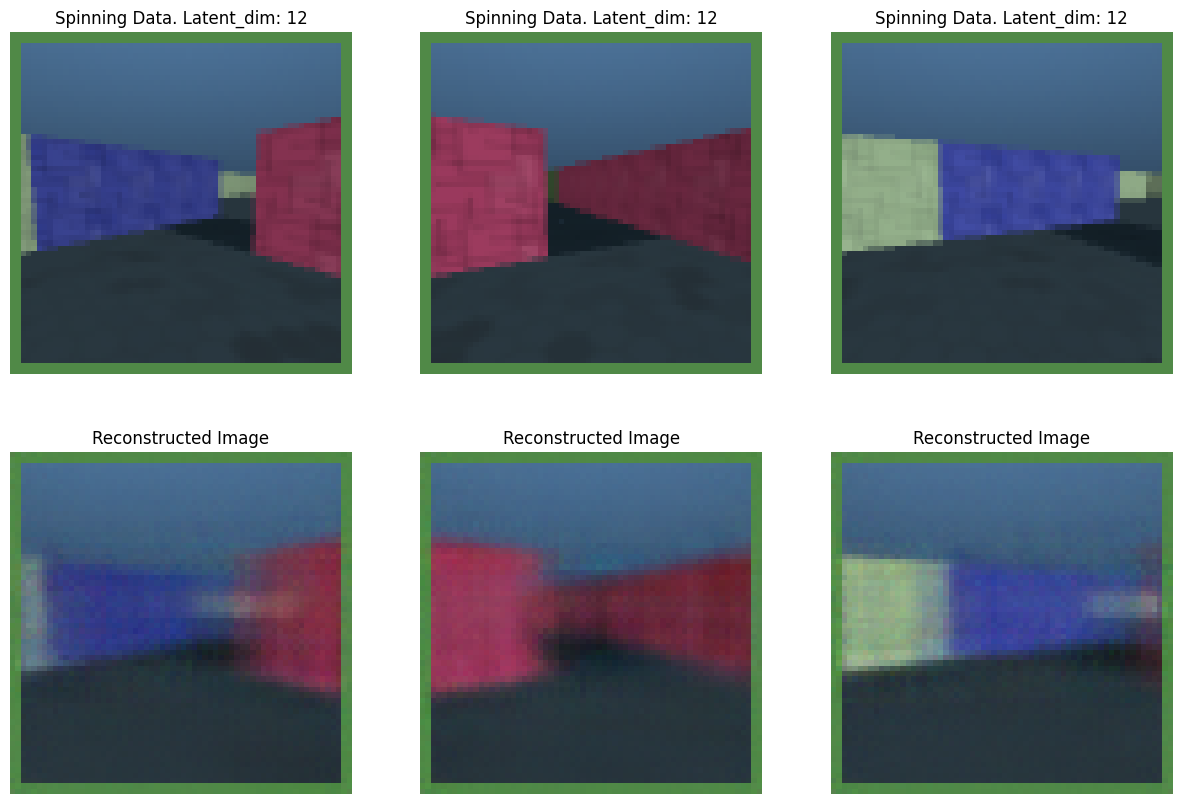

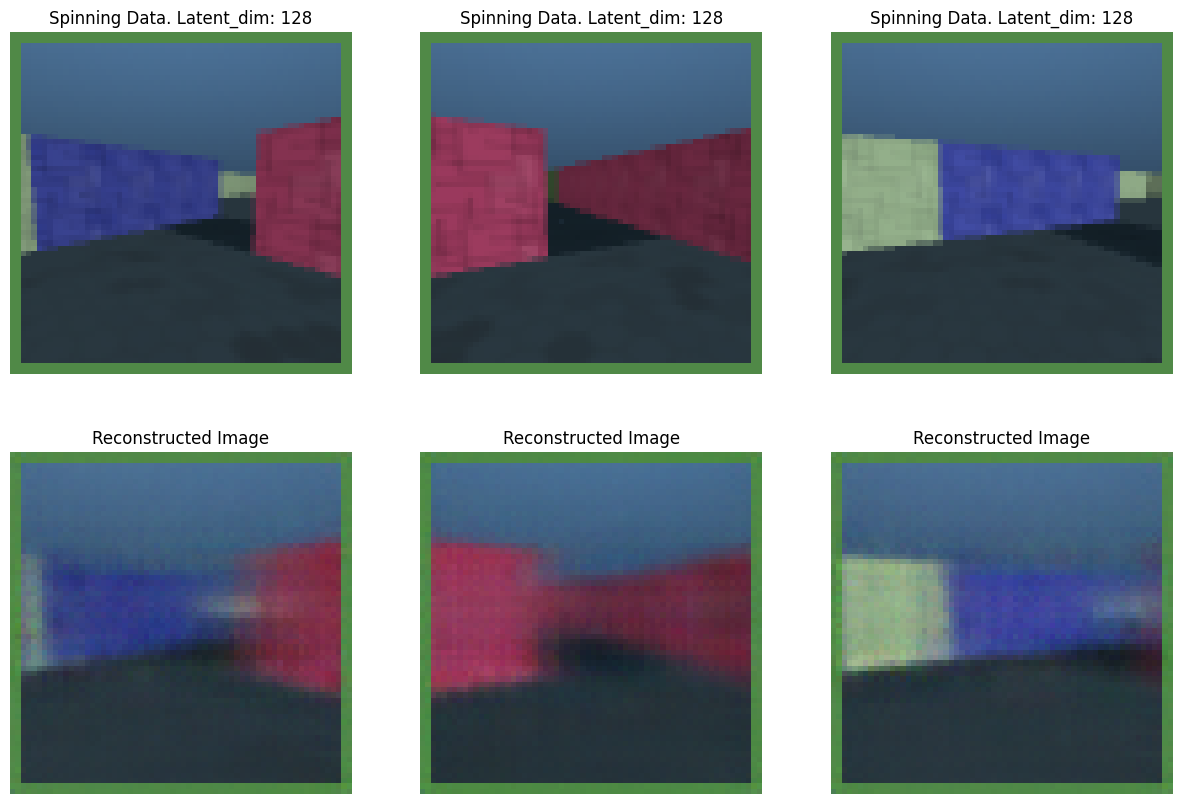

In [40]:

# Spinning data
for latent_dim in latent_dims_spinning:
    model = Autoencoder(latent_dim)
    model.load_state_dict(torch.load(f'data/spinning_data_{latent_dim}.pt', map_location=torch.device('cpu')))
    model.eval()
    test_reconstruction(model, spinning_data_test_images, random_seed=125, name_of_model = "Spinning Data. Latent_dim: "+str(latent_dim))


We can see that the no pruning and spinning case work, the pruned dataset does not work well. 

# Latent space analysis 

Barcode for entire_maze_data_no_pruning with latent dim: 3


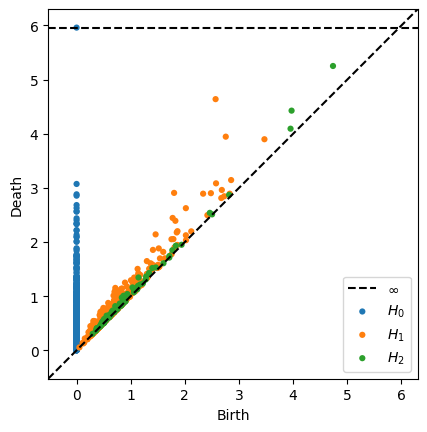

Barcode for entire_maze_data_no_pruning with latent dim: 12


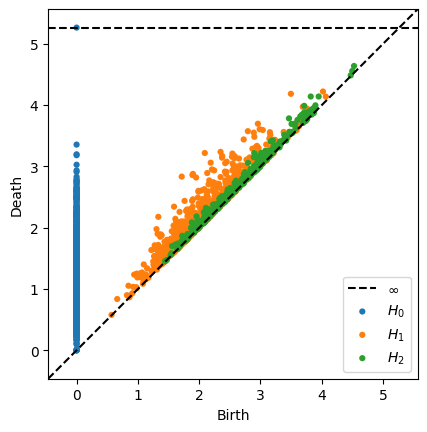

Barcode for entire_maze_data_no_pruning with latent dim: 128


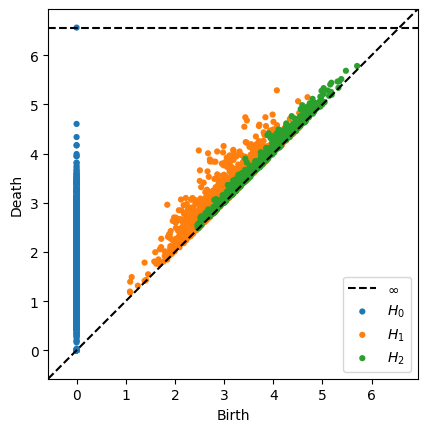

Barcode for entire_maze_data_with_pruning with latent dim: 3


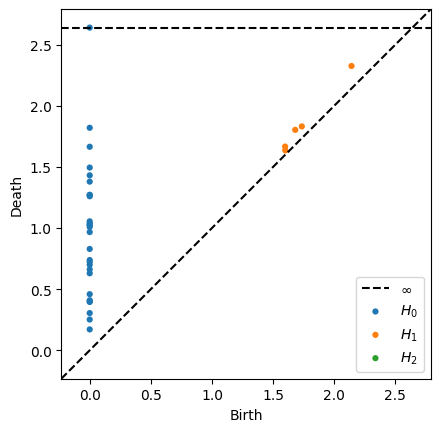

Barcode for entire_maze_data_with_pruning with latent dim: 12


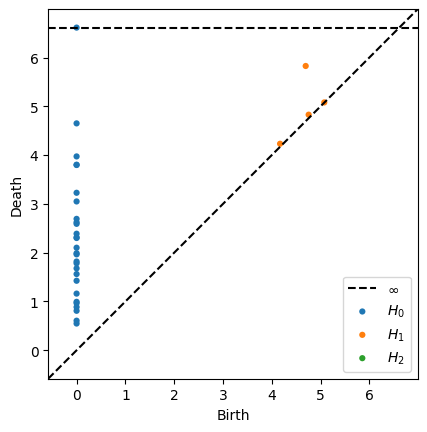

Barcode for entire_maze_data_with_pruning with latent dim: 128


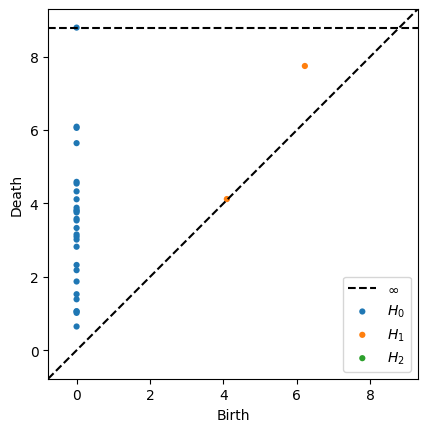

Barcode for spinning_data with latent dim: 2


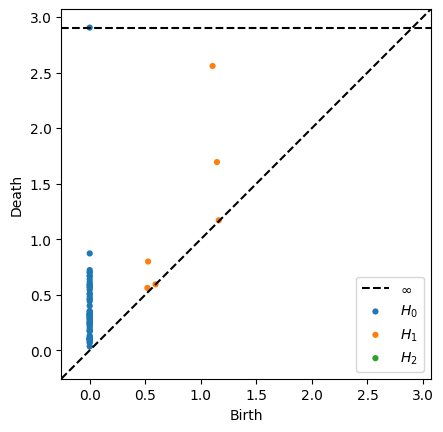

Barcode for spinning_data with latent dim: 12


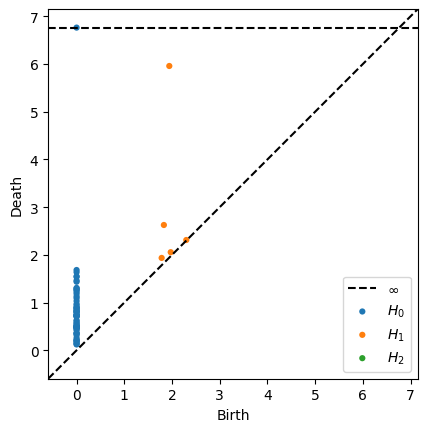

Barcode for spinning_data with latent dim: 128


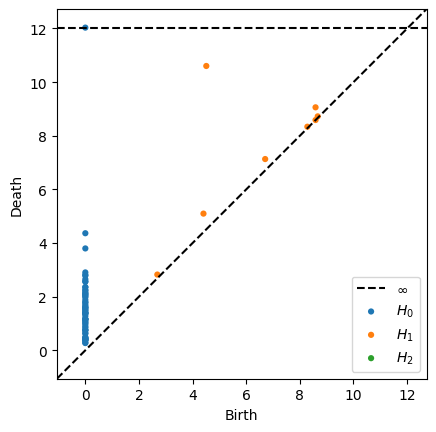

In [41]:
# Use plotly to make a 3D plot of the PCA data
import plotly.express as px
import pandas
import numpy as np
import plotly.graph_objects as go

def plot_pca_3d(pca_data, name_of_model):
    if  pca_data.shape[1] > 2:
        df = pandas.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
        fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', title=name_of_model, width=800, height=800)
        fig.update_traces(marker=dict(size=4))  # Set marker size to 2
        fig.write_html("data/"+ name_of_model + "_pca_3d_plot.html")
        fig.show()
        return
    else:
        df = pandas.DataFrame(pca_data, columns=['PC1', 'PC2'])
        fig = px.scatter(df, x='PC1', y='PC2', title=name_of_model, width=800, height=800)
        fig.update_traces(marker=dict(size=4))


# Plotting the barcode plots
def plot_barcode(barcode, name_of_model):
    fig = plt.figure()
    plot_diagrams(barcode, show=True)


# Entire maze data no pruning
for i, latent_dim in enumerate(latent_dims_entire):
    plot_pca_3d(pca_entire_maze_data_no_pruning[i], "entire maze dataset_Latent dim_"+str(latent_dim))
    print("Barcode for entire_maze_data_no_pruning with latent dim: "+str(latent_dim))
    plot_barcode(barcode_entire_maze_data_no_pruning[i], "entire_maze_data_no_pruning_"+str(latent_dim))

# Entire maze data with pruning
for i, latent_dim in enumerate(latent_dims_entire):
    plot_pca_3d(pca_entire_maze_data_with_pruning[i], "entire_maze_data_with_pruning_"+str(latent_dim))
    print("Barcode for entire_maze_data_with_pruning with latent dim: "+str(latent_dim))
    plot_barcode(barcode_entire_maze_data_with_pruning[i], "entire_maze_data_with_pruning_"+str(latent_dim))

# Spinning data
for i, latent_dim in enumerate(latent_dims_spinning):
    plot_pca_3d(pca_spinning_data[i], "spinning_data_"+str(latent_dim))
    print("Barcode for spinning_data with latent dim: "+str(latent_dim))
    plot_barcode(barcode_spinning_data[i], "spinning_data_"+str(latent_dim) )

